In [1]:
import sys
import os
from importlib import reload
import numpy as np

sys.path.insert(0, '../../src')
import deepgeo.common.filesystem as fs
import deepgeo.common.geofunctions as gf
import deepgeo.common.visualization as vis
import deepgeo.dataset.image_utils as iutils

In [2]:
DATA_DIR = '/home/raian/doutorado/Dados/2018/test_clouds'
band_names = ['QA', 'Green', 'Red', 'NIR', 'SWIR_1', 'SWIR_2']
# band_names = ['Green', 'Red', 'NIR', 'SWIR_1', 'SWIR_2']
INPUT_DIR = os.path.join(DATA_DIR, 'sep_bands')
OUTPUT_DIR = os.path.join(DATA_DIR, 'generated')

In [4]:
# TODO: AUTOMATE THIS WITH file.glob
input_files = {#'20180317': {'folder': 'LC082250632018031701T2-SC20190428131240',
#                             'file': 'LC08_L1GT_225063_20180317_20180402_01_T2_'},
#                '20180402': {'folder': 'LC082250632018040201T2-SC20190428131217',
#                             'file': 'LC08_L1GT_225063_20180402_20180416_01_T2_'},
#                '20180418': {'folder': 'LC082250632018041801T2-SC20190428131300',
#                             'file': 'LC08_L1GT_225063_20180418_20180501_01_T2_'},
#                '20180520': {'folder': 'LC082250632018052001T2-SC20190428131213',
#                             'file': 'LC08_L1GT_225063_20180520_20180605_01_T2_'},
#                '20180605': {'folder': 'LC082250632018060501T2-SC20190428131257',
#                             'file': 'LC08_L1TP_225063_20180605_20180615_01_T2_'},
               '20180723': {'folder': 'LC082250632018072301T1-SC20190428131245',
                            'file': 'LC08_L1TP_225063_20180723_20180731_01_T1_'}}

classes_of_interest = [['d2018']]
non_class = 'not_deforestation'
class_column = 'class_name'
class_names = ['not_deforestation', 'deforestation']

out_labels = [os.path.join(DATA_DIR, 'labels_cloudless.tif')]
input_shps = os.path.join(DATA_DIR, '../../prodes_2018', 'PDigital2018_22563__pol.shp')

output_file_name = 'LC08_L1TP_225063_'  #TODO: In the function before, complete this with the date used as key above and .tif extension

Stacking images from  20180723


/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


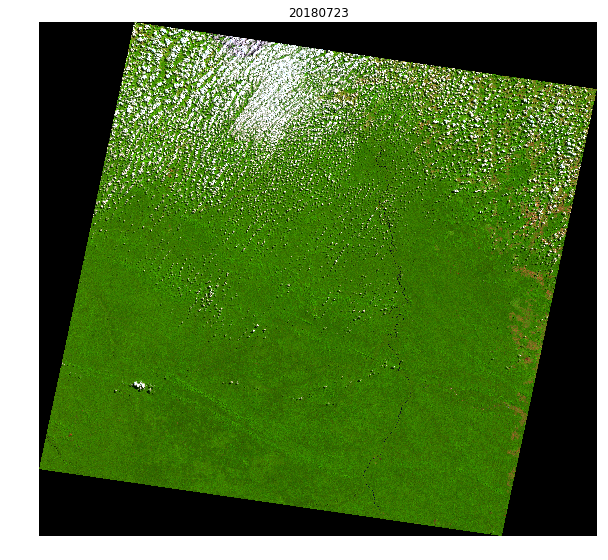

In [5]:
fs.mkdir(OUTPUT_DIR)
for date, ff in input_files.items():
    print('Stacking images from ', date)
    raster_bands = [os.path.join(INPUT_DIR, ff['folder'], (ff['file'] + 'pixel_qa.tif'))]
    for i in range(3, 8):
        file_name = os.path.join(INPUT_DIR, ff['folder'], (ff['file'] + 'sr_band' + str(i) + '.tif'))
        raster_bands.append(file_name)

    out_img = os.path.join(OUTPUT_DIR, (output_file_name + date + '.tif'))
    iutils.stack_bands(raster_bands, out_img, band_names)
    iutils.clip_by_aggregated_polygons(out_img, input_shps, out_img, band_names=band_names)
    raster_img = gf.load_image(out_img, no_data=-9999)
    vis.plot_rgb_img(raster_img, bands=[4,3,2], contrast=True, title=date)

SHAPE:  (6169, 6706, 1)


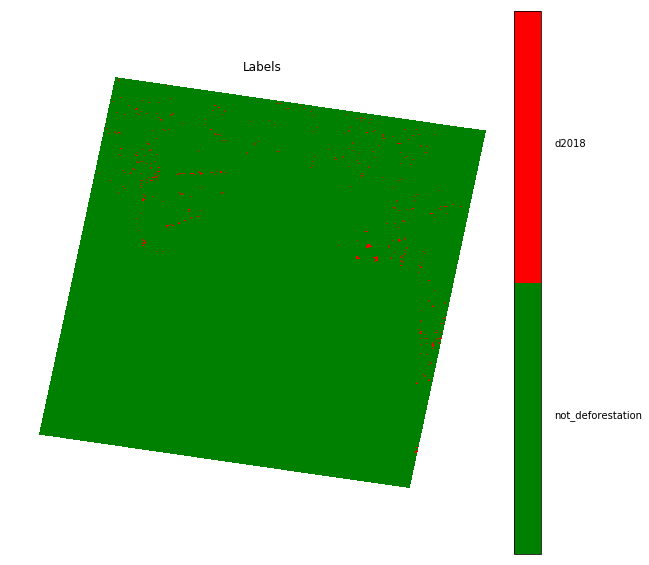

In [9]:
cloudy_list = [os.path.join(OUTPUT_DIR, 'LC08_L1TP_225063_20180317.tif'),
               os.path.join(OUTPUT_DIR, 'LC08_L1TP_225063_20180402.tif'),
               os.path.join(OUTPUT_DIR, 'LC08_L1TP_225063_20180418.tif'),
               os.path.join(OUTPUT_DIR, 'LC08_L1TP_225063_20180520.tif'),
               os.path.join(OUTPUT_DIR, 'LC08_L1TP_225063_20180605.tif'),
               os.path.join(OUTPUT_DIR, 'LC08_L1TP_225063_20180723.tif')]

import deepgeo.dataset.rasterizer as rstzr
rasterized_layers = []
for year in range(0, len(classes_of_interest)):
    rasterizer = rstzr.Rasterizer(input_shps,
                                  cloudy_list[-1],
                                  class_column,
                                  classes_interest=classes_of_interest[year],
                                  non_class_name=non_class)

    rasterizer.collect_class_names()
    rasterizer.rasterize_layer()
    m_class_names = rasterizer.get_class_names()
    rasterized_layers.append(rasterizer.get_labeled_raster())
    rasterizer.save_labeled_raster_to_gtiff(out_labels[year])
    print('SHAPE: ', rasterized_layers[year].shape)
    
    vis.plot_labels(rasterized_layers[year], m_class_names, colors=["green", "red"])

In [21]:
from osgeo import gdal
import skimage
import matplotlib.pyplot as plt
from skimage import exposure

out_img = os.path.join(OUTPUT_DIR, 'LC08_L1TP_225063_cloudless.tif')

def compute_cloud_mask(img_array, qa_pos=0):
    band_qa = img_array[:, :, qa_pos]
    
    cloud_shadow = [328, 392, 840, 904, 1350]
    cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
    high_confidence_cloud = [480, 992]
    all_masked_values = cloud + high_confidence_cloud + cloud_shadow
    cl_mask = np.zeros(band_qa.shape)
    for cval in all_masked_values:
        cl_mask[band_qa == cval] = 1
        
    return cl_mask

def compose_cloudless_image_median(path_list, out_path):
    mask_list = []
    arr_list = []
    for file in path_list:
        img_ds = gdal.Open(file)
        img_arr = img_ds.ReadAsArray()
        img_arr = np.rollaxis(img_arr, 0, 3)
        cl_mask = compute_cloud_mask(img_arr, 0)
        mask_list.append(cl_mask)
        num_bands = img_arr.shape[2]
        arr_list.append(img_arr[:,:, 1:])
    
    new_arr = np.copy(arr_list[-1])
    for j in range(len(arr_list)):
        mask_orig = np.expand_dims(mask_list[0], -1)
        mask_orig = np.broadcast_to(mask_orig == 1, arr_list[0].shape)
        mask_cur = np.expand_dims(mask_list[j], -1)
        mask_cur = np.broadcast_to(mask_cur == 1, arr_list[j].shape)
        new_arr = np.where(np.logical_and(mask_orig, np.logical_not(mask_cur)), arr_list[j], new_arr)

    in_ds = gdal.Open(path_list[0])
    in_band = in_ds.GetRasterBand(1)
    size_x = in_band.XSize
    size_y = in_band.YSize
    
    driver = gdal.GetDriverByName('GTiff')
    nbands = new_arr.shape[2]
    datatype = in_band.DataType
    output_ds = driver.Create(out_path, size_x, size_y, nbands, datatype)
    
    for band in range(nbands):
        output_ds.SetProjection(in_ds.GetProjection())
        output_ds.SetGeoTransform(in_ds.GetGeoTransform())
        output_band = output_ds.GetRasterBand(band + 1)
        output_band.SetNoDataValue(in_band.GetNoDataValue())
        output_band.WriteArray(new_arr[:,:,band])
    output_ds = None
    input_ds = None
    
def compose_cloudless_label(labels, image, pos_qa, output_path, new_label=0):
    img_ds = gdal.Open(image)
    img_arr = img_ds.ReadAsArray()
    img_arr = np.rollaxis(img_arr, 0, 3)
    cl_mask = compute_cloud_mask(img_arr, 0)
    num_bands = img_arr.shape[2]
    
    mask = np.expand_dims(cl_mask, -1)
    mask = mask == 1
    print(labels.shape)
    labels[mask] = new_label
    
    vis.plot_labels(labels, m_class_names, colors=['green', 'red'])
    
    driver = gdal.GetDriverByName('GTiff')
    out_x_size = img_ds.GetRasterBand(1).XSize
    out_y_size = img_ds.GetRasterBand(1).YSize
    output_ds = driver.Create(output_path, out_x_size, out_y_size, 1)
    output_ds.SetProjection(img_ds.GetProjection())
    output_ds.SetGeoTransform(img_ds.GetGeoTransform())
    output_band = output_ds.GetRasterBand(1)
    output_band.WriteArray(np.ma.filled(labels[:, :, 0], 0))
#     output_band.FlushCache()
#     output_ds = None

(6169, 6706, 1)


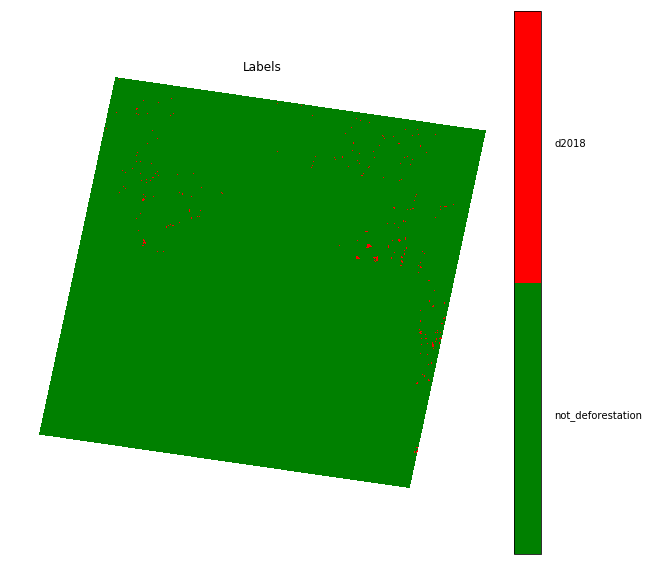

In [22]:
compose_cloudless_label(rasterized_layers[0], cloudy_list[-1], 0, out_labels[0], new_label=1)

In [ ]:
# compose_cloudless_image_median(cloudy_list, out_img)

In [ ]:
# TODO: Check this in TerraView
# raster_img = gf.load_image(out_img, no_data=-9999)
# vis.plot_rgb_img(raster_img, bands=[3,2,1], contrast=True, title=date)